In [45]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import scipy.io as scio

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Input,Dense,RepeatVector,BatchNormalization,Activation,Dropout
from keras.optimizers import  Adam
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import recall_score,classification_report,auc,roc_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score

from numpy.random import seed
seed(1)

os.environ['PYTHONHASHSEED']=str(0)
SEED=2019
DATA_SPLIT_PCT=0.2

nb_epoch=200
batch_size=64
input_dim=152
encoding_dim=64
hidden_dim=int(encoding_dim/2)
learning_rate=1e-3

In [46]:
# Import pandas library
import pandas as pd
import numpy as np
# Read csv data file
# Data without feature standardization
df = pd.read_csv('Labelled50GapRandom_LabelSc.csv')
# View the number of rows and columns
df.head()
df.dtypes
df.shape

(2169, 153)

In [47]:
# Import LabelEncoder
from sklearn import preprocessing
# Create LabelEncoder
le = preprocessing.LabelEncoder()

In [48]:
# Indicate the target column
target = df['Label_mL']
# Indicate the columns that will serve as features
features = df.drop('Label_mL', axis = 1)

In [49]:
'''
features = df[[  'Signal012',
                'Signal013',
                'Signal112',
                'Signal711',
                'Signal712',
                'Signal713',
                'Signal714' ]]   
print(features.shape)
'''

"\nfeatures = df[[  'Signal012',\n                'Signal013',\n                'Signal112',\n                'Signal711',\n                'Signal712',\n                'Signal713',\n                'Signal714' ]]   \nprint(features.shape)\n"

In [50]:
# Split data into train, validation and test sets
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Split the dataset into training + development set and test set
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.4, random_state = 0)
# Split the dataset into training set and development set
#x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size = 0.4, random_state = 10)
y_test_cate=to_categorical(y_test,num_classes=11)
y_train_cate=to_categorical(y_train,num_classes=11)
#数据标准化
scaler=StandardScaler().fit(x_train)
x_train_rescaled=scaler.transform(x_train)
x_test_rescaled=scaler.transform(x_test)
print(x_test.shape)

(868, 152)


In [51]:
PRE=[]
TRUE=[]
ACC=[]
for i in range(10):
#autoencoder
    input_layer=Input(shape=(input_dim,))
#编码层
    encoder=Dense(encoding_dim,activation="relu")(input_layer)

    encoder=Dense(hidden_dim,activation="relu")(encoder)
#解码层
    decoder=Dense(hidden_dim,activation="sigmoid")(encoder)

    decoder=Dense(encoding_dim,activation="sigmoid")(decoder)

    aux_output=Dense(input_dim,activation="linear",name='autoencoder')(decoder)
#fenleiqi
    LR=Dense(11,activation="softmax",name='LR')(encoder)

    autoencoder=Model(inputs=input_layer,outputs=LR)

    # Training
# 选择评价函数，选择优化器，指定损失函数
    autoencoder.compile(metrics=['accuracy'],
                        loss= ['categorical_crossentropy'],
                        optimizer=Adam(lr=learning_rate),
                        loss_weights= 1)

    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                        save_best_only=True,
                        monitor='val_LR_accuracy',
                        verbose = 0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    history = autoencoder.fit(x_train_rescaled,y_train_cate,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(x_test_rescaled, y_test_cate),
                          verbose=0).history
    acc=autoencoder.evaluate(x_test_rescaled,y_test_cate)
    pre=autoencoder.predict(x_test_rescaled)
    y_pred=np.argmax(pre,axis=1)
    PRE.append(y_pred)
    TRUE.append(y_test)
    ACC.append(acc[1])
print(np.mean(ACC),np.std(ACC))


28/28 [==============================] - 0s 513us/step - loss: 0.0397 - accuracy: 0.9965
0.9971198081970215 0.0007728376254959564


In [52]:
pre_y=np.array(PRE).reshape(8680)
true_y=np.array(TRUE).reshape(8680)

In [53]:
# Import scikit-learn metrics methods
from sklearn.metrics import classification_report, confusion_matrix
# Print confusion matrix
print(confusion_matrix(pre_y, true_y))
# Print precision, recall and F1
print(classification_report(pre_y, true_y))

[[910   0   0   0   0   0   0   0   0   0   0]
 [  0 870   0   0   0   4   0   0   0   0   0]
 [  0   0 750   0   0   0   0   0   0   0   0]
 [  0   0   0 810   0   0   0   0   0   0   0]
 [  0   0   0   0 760   0   0   0   0   0   0]
 [  0   0   0   0   0 585   0   0   0   0   0]
 [  0   0   0   0   0   1 750   0   0   0   0]
 [  0   0   0   0   0  10   0 770   0  10   0]
 [  0   0   0   0   0   0   0   0 890   0   0]
 [  0   0   0   0   0   0   0   0   0 790   0]
 [  0   0   0   0   0   0   0   0   0   0 770]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       910
           1       1.00      1.00      1.00       874
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       810
           4       1.00      1.00      1.00       760
           5       0.97      1.00      0.99       585
           6       1.00      1.00      1.00       751
           7       1.00      0.97      0.99      

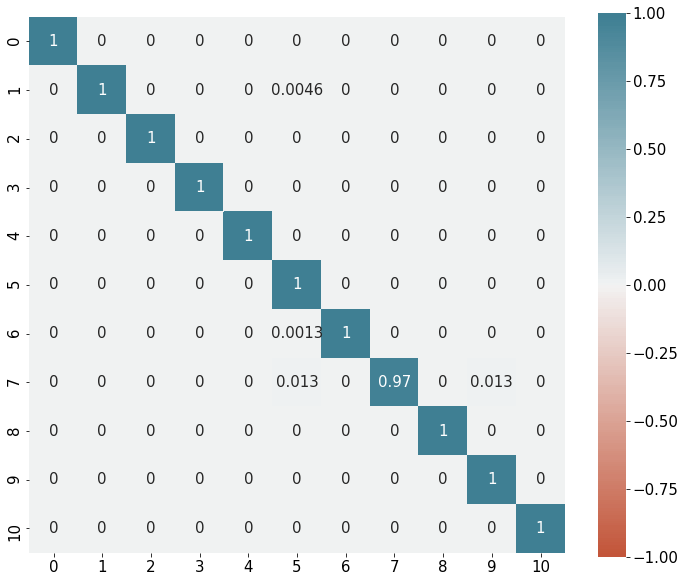

In [61]:
# Generating the correlation heatmap is optional
# The heatmap is just a visualization of the correlation matrix
# Import seaborn package to generate heatmap
import seaborn as sns
# Import pyplot to control the size of the plot
import matplotlib.pyplot as plt
# Set plot size
plt.rcParams.update({'font.size': 15, 'figure.figsize': (10, 8)})
plt.figure(figsize=(12,10))
# Generate the heatmap
ax = sns.heatmap(confusion_matrix(pre_y, true_y,normalize='true'),
 vmin = -1, vmax = 1, center = 0,
 cmap = sns.diverging_palette(20, 220, n=200),
 square = True,
 annot = True
                )